In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
site = 'TKL524'

path_to_meteo_file = f'/home/amullen/LAKE_NSF/meteo/{site}.dat'
path_to_inflows = f'/home/amullen/LAKE_NSF/meteo/{site}_inflows.dat'
path_to_outflows = f'/home/amullen/LAKE_NSF/meteo/{site}_outflows.dat'

max_depth = 2.5

In [3]:
meteo_df = pd.read_csv(path_to_meteo_file)

In [4]:
#inflows
inflows_df = pd.DataFrame(columns=['Date', 'width', 'U', 'temp', 'sal', 'Ux', 'Uy', 'DOC', 'POC', 'DIC', 'CH4', 'O2']) #for tribheat=2
inflows_df['Date'] = pd.to_datetime(meteo_df[['Year', 'Month', 'Day']])
inflows_df = inflows_df.fillna(-999)

#only required columns are 'width' and 'U', everything not given a real value should be -999
inflows_df['width'] = 0.0
inflows_df['U'] = 0.0 #m/s Dabrowski et al., 2020
#inflows_df['CH4'] = 0.370 #mol/m3, Dabrowski et al., 2020 YKD
inflows_df['temp'] = -999

In [5]:
#outflows
outflows_df = pd.DataFrame(columns=['Date', 'width', 'U'])
outflows_df['Date'] = pd.to_datetime(outflows_df['Date'])
outflows_df['Date'] = inflows_df['Date']
outflows_df['width'] = inflows_df['width']
outflows_df['U'] = inflows_df['U']

In [6]:
twater_obs = pd.read_csv('in_situ/water_temp_depth_cleaned.csv', parse_dates=['time'])
twater_obs = twater_obs.groupby(by=[twater_obs['time'].dt.date, 'site']).mean().reset_index()
twater_obs['diff'] = np.nan

for s in twater_obs['site'].unique():

    twater_obs.loc[twater_obs['site']==s, 'diff'] = twater_obs.loc[twater_obs['site']==s, 'depth_m'].diff(periods=-1)

twater_obs['time'] = pd.to_datetime(twater_obs['time'])

/tmp/ipykernel_63511/3397891064.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  twater_obs = twater_obs.groupby(by=[twater_obs['time'].dt.date, 'site']).mean().reset_index()


In [7]:
twater_obs['depth_m']

0      0.760000
1      1.568718
2      0.844167
3      0.903585
4      1.549896
         ...   
308   -0.055833
309   -0.098229
310         NaN
311   -0.068333
312   -0.109259
Name: depth_m, Length: 313, dtype: float64

In [8]:
twater_obs['diff']

0     -0.084167
1      0.018822
2      0.007917
3     -0.124019
4     -0.020104
         ...   
308    0.012500
309    0.011030
310         NaN
311         NaN
312         NaN
Name: diff, Length: 313, dtype: float64

<Axes: xlabel='time', ylabel='diff'>

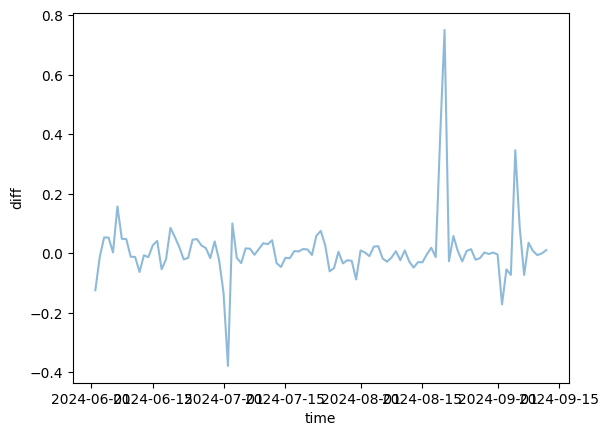

In [9]:
sns.lineplot(data = twater_obs.loc[twater_obs['site']==site], x='time', y='diff', alpha=0.5)

In [10]:
outflows_df = outflows_df.merge(twater_obs.loc[twater_obs['site']==site][['time', 'diff']], left_on='Date', right_on='time', how='left')

In [11]:
outflows_df.loc[~np.isnan(outflows_df['diff']), 'U'] = outflows_df.loc[~np.isnan(outflows_df['diff']), 'U'] + outflows_df.loc[~np.isnan(outflows_df['diff']), 'U'] * (outflows_df.loc[~np.isnan(outflows_df['diff']), 'diff']/max_depth) * -1

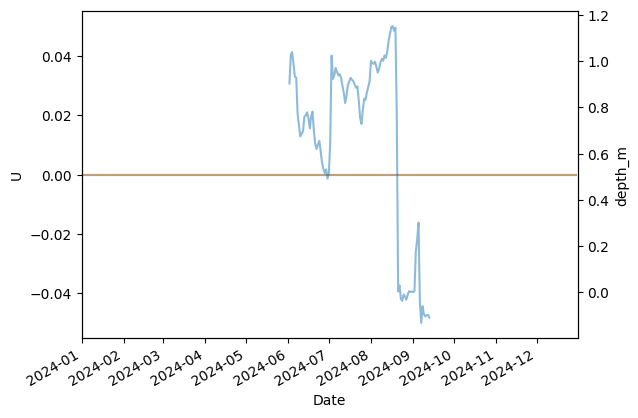

In [12]:
fig, ax = plt.subplots()

ax2=ax.twinx()

sns.lineplot(data = inflows_df, x='Date', y='U', alpha=0.5, ax=ax)
sns.lineplot(data = outflows_df, x='Date', y='U', alpha=0.5, ax=ax)
sns.lineplot(data = twater_obs.loc[twater_obs['site']==site], x='time', y='depth_m', alpha=0.5, ax=ax2)


ax.set_xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-12-31'))

fig.autofmt_xdate()

In [13]:
inflows_df['Date'] = inflows_df['Date'].dt.strftime('%Y%m%d')
outflows_df['Date'] = outflows_df['Date'].dt.strftime('%Y%m%d')

In [14]:
outflows_df

,Date,width,U,time,diff
0,20210701,0.0,0.0,NaT,NaN
1,20210702,0.0,0.0,NaT,NaN
2,20210703,0.0,0.0,NaT,NaN
3,20210704,0.0,0.0,NaT,NaN
4,20210705,0.0,0.0,NaT,NaN
...,...,...,...,...,...
1274,20241226,0.0,0.0,NaT,NaN
1275,20241227,0.0,0.0,NaT,NaN
1276,20241228,0.0,0.0,NaT,NaN
1277,20241229,0.0,0.0,NaT,NaN


In [15]:
inflows_df.to_csv(path_to_inflows, index=False, header=False)
outflows_df[['Date','width','U']].to_csv(path_to_outflows, index=False, header=False)